# Scraping Teletherapy App Data from the Apple App Store

This notebook uses the app_store_scraper package to scrape the Apple app store for the reviews of 10 digital therapy apps to examine issues and risks associated with them. It also uses the sklearn, pystemmer and eli5 packages to build a classifer to predict whether users who wrote 1-star and 2-star reviews on 6 of the 10 apps expressed that they were unfairly charged, had an unresponsive therapist, or an unhelpful therapist. 

Apps were selected based on search results for "therapy" and "CBT" on the app store, as well as online reviews of mental health apps. The dataframe containing their names and ids is manually created here.

## Imports

In [ ]:
!pip install itunes-app-scraper-dmi==0.9.4
!pip install app-store-scraper==0.3.5

In [101]:
import pandas as pd

from itunes_app_scraper.scraper import AppStoreScraper
from app_store_scraper import AppStore

import time
import re

import requests
from plotnine import * 

In [297]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 300)

## Building dataframe of 10 apps 

This section builds a dataframe of the therapy apps to analyze from the App Store website (https://www.apple.com/app-store/). The names and ids of the apps are in each of their App store URLs

The apps are:
- [Talkspace](https://apps.apple.com/us/app/talkspace-therapy-counseling/id661829386) 
- [Betterhelp](https://apps.apple.com/us/app/betterhelp-therapy/id995252384)
- [Wysa](https://apps.apple.com/us/app/wysa-mental-health-support/id1166585565)
- [Bloom](https://apps.apple.com/us/app/bloom-cbt-therapy-self-care/id1475128511)
- [7 Cups](https://apps.apple.com/us/app/7-cups-online-therapy-chat/id921814681)
- [Sanvella](https://apps.apple.com/us/app/sanvello-anxiety-depression/id922968861)
- [WoeBot](https://apps.apple.com/us/app/woebot-your-self-care-expert/id1305375832) 
- [Larkr](https://apps.apple.com/us/app/larkr-on-demand-video-therapy/id1253710426)
- [Youper](https://apps.apple.com/us/app/youper-online-therapy/id1060691513)
- [Cerebral](https://apps.apple.com/us/app/cerebral-mental-health/id1537193671)

In [43]:
app_names_ids = [
    {'name':'talkspace-therapy-counseling',
    'id': 661829386},
    {'name':'betterhelp-therapy',
    'id':995252384},
    {'name': 'wysa-mental-health-support',
    'id':1166585565},
    {'name': 'bloom-cbt-therapy-self-care',
    'id':1475128511},
    {'name': '7-cups-online-therapy-chat',
    'id':921814681},
    {'name': 'sanvello-anxiety-depression',
    'id':922968861},
    {'name': 'woebot-your-self-care-expert',
    'id':1305375832},
    {'name': 'larkr-on-demand-video-therapy',
    'id':1253710426},
    {'name':'youper-online-therapy',
    'id':1060691513},
    {'name': 'cerebral-mental-health',
    'id':1537193671}]

In [44]:
therapy_apps = pd.DataFrame(app_names_ids)

In [45]:
therapy_apps

,name,id
0,talkspace-therapy-counseling,661829386
1,betterhelp-therapy,995252384
2,wysa-mental-health-support,1166585565
3,bloom-cbt-therapy-self-care,1475128511
4,7-cups-online-therapy-chat,921814681
5,sanvello-anxiety-depression,922968861
6,woebot-your-self-care-expert,1305375832
7,larkr-on-demand-video-therapy,1253710426
8,youper-online-therapy,1060691513
9,cerebral-mental-health,1537193671


## Scraping reviews for the apps

In [ ]:
all_reviews = []
for app in app_names_ids:
    my_app = AppStore(
      country='us',       
      app_name=app['name'], 
      app_id=app['id']    
    ) 

    my_app.review(
      how_many=1500,
      after=pd.to_datetime('2020-01-01'),
      sleep=1,
    )
    
    reviews = my_app.reviews
    
    for review in reviews:
        review['app_name'] = app['name']
        review['app_id'] = app['id']
        
    reviews_df = pd.DataFrame(reviews)
    all_reviews.append(reviews_df)
    time.sleep(5)

In [47]:
all_reviews_df = pd.concat(all_reviews)

## Analysis

In [48]:
all_reviews_df.head()

,rating,isEdited,developerResponse,userName,date,review,title,app_name,app_id
0,4,False,"{'id': 27789946, 'body': 'Hi there, thank you ...",Gab_Stan,2022-01-30 16:15:22,I always wanted to try therapy but wasn’t sure...,Online therapy during a pandemic is extremely ...,talkspace-therapy-counseling,661829386
1,1,False,"{'id': 26038969, 'body': 'Hi there, thank you ...",texasbaby27,2021-10-29 13:00:33,Give me all of my money back. I don’t write ap...,Refund. Me. Now.,talkspace-therapy-counseling,661829386
2,1,True,"{'id': 25748189, 'body': 'Hi there, thank you ...",Person adjusnduwjxuwiud,2021-11-28 16:16:18,I paid hundreds of dollars just for my psychia...,NOT SAFE! Please do not use!!!,talkspace-therapy-counseling,661829386
3,1,False,"{'id': 25725582, 'body': 'Hi there, thank you ...",newbreviewb,2021-10-13 14:42:30,"I signed up for this app on Saturday, searched...",Complete and total silence,talkspace-therapy-counseling,661829386
4,1,False,NaN,starrienightsz,2022-02-09 18:36:59,This app is a joke. I’ve never had any issues ...,Only do it if your employer sponsors it,talkspace-therapy-counseling,661829386


In [49]:
all_reviews_df.rating.value_counts()

5    5985
1    1869
4     639
2     375
3     307
Name: rating, dtype: int64

In [ ]:
all_reviews_df.to_csv('scraped_reviews.csv')

### Insurance issues

Talkspace has 82 insurance related 1-star ratings

In [96]:
insurance_woes = []
for count, review in enumerate(list(all_reviews_df.review)):
    reviews = review.split('. ')
    matches = [sentence for sentence in reviews if re.findall('insurance', sentence, re.IGNORECASE)]
    if len(matches) != 0:
        woe = {}
        woe['review'] = matches
        woe['app_name'] = all_reviews_df.iat[count,7]
        woe['rating'] = all_reviews_df.iat[count,0]
        insurance_woes.append(woe)

In [221]:
insurance_woes = pd.DataFrame(insurance_woes)

In [222]:
insurance_woes['rating_str'] = insurance_woes.rating.astype(str)

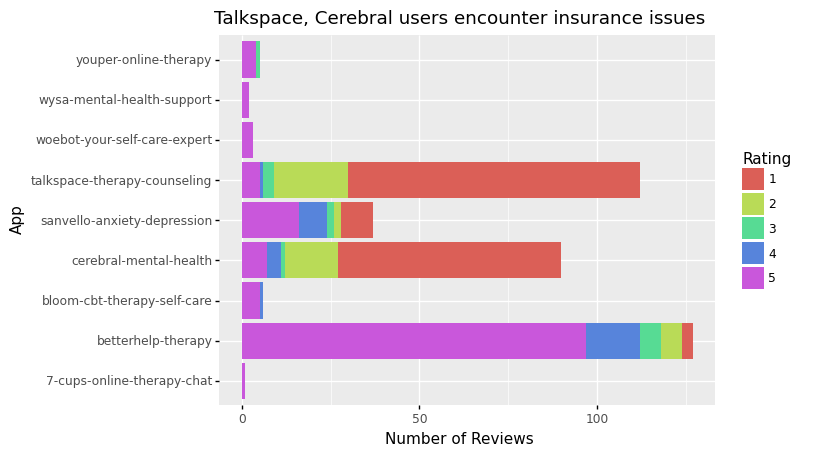

<ggplot: (330265588)>

In [230]:
display(
    ggplot(insurance_woes)
    + geom_bar(aes('app_name', fill='rating_str'))
    + coord_flip()
    + labs(title='Talkspace, Cerebral users encounter insurance issues', 
           fill='Rating',
           x='App',
           y='Number of Reviews')
)

In [147]:
all_reviews_df.app_name.value_counts()

betterhelp-therapy              1512
woebot-your-self-care-expert    1505
youper-online-therapy           1504
talkspace-therapy-counseling    1149
wysa-mental-health-support      1045
cerebral-mental-health           753
sanvello-anxiety-depression      691
bloom-cbt-therapy-self-care      676
7-cups-online-therapy-chat       340
Name: app_name, dtype: int64

In [486]:
review_counts = all_reviews_df.app_name.value_counts().reset_index(name='total')

In [490]:
review_counts.rename(columns={'index':'app_name'},inplace=True)

Re-styling the visualization in DataWrapper

In [482]:
reformatted = insurance_woes.groupby(['app_name', 'rating']).size().reset_index(name='num_reviews')\
                .pivot(index='rating', columns='app_name', values='num_reviews')

In [495]:
reformatted = reformatted[['betterhelp-therapy', 'cerebral-mental-health', 'sanvello-anxiety-depression', 'talkspace-therapy-counseling']]

In [497]:
reformatted.to_csv('insurance-chart-data.csv')

<img src=insurance.png>

### Suicidal ideation

At least three reviewers mentioned they were contemplating suicide in a negative review

In [345]:
suicidial_ideation = []
for count, review in enumerate(list(all_reviews_df.review)):
    reviews = review.split('. ')
    matches = [sentence for sentence in reviews if re.findall('end it all|kill myself|suicide', sentence, re.IGNORECASE)]
    if len(matches) != 0:
        match = {}
        match['review'] = matches
        match['app_name'] = all_reviews_df.iat[count,7]
        match['rating'] = all_reviews_df.iat[count,0]
        suicidial_ideation.append(match)

In [346]:
suicidial_ideation

[{'review': ['because i mentioned i had PASSIVE thoughts about suicide, they wouldn’t help me'],
  'app_name': 'talkspace-therapy-counseling',
  'rating': 1},
 {'review': ['This app is terrible because you have to pay to prevent suicide makes sense'],
  'app_name': 'talkspace-therapy-counseling',
  'rating': 1},
 {'review': ['The only  number provided to help you is the suicide prevention hotline'],
  'app_name': 'betterhelp-therapy',
  'rating': 1},
 {'review': ['My son was 20 and committed suicide after a painful 2 years due to psychosis as a result of a trauma'],
  'app_name': 'betterhelp-therapy',
  'rating': 5},
 {'review': ['I was the closest to suicide I think I’d ever gotten, and no one knew'],
  'app_name': 'wysa-mental-health-support',
  'rating': 5},
 {'review': ['My uncle committed suicide I felt like I needed a therapist but I couldn’t because of coronavirus around so I found this and it has been helping me so much with my stress and anxiety.'],
  'app_name': 'wysa-mental-

## Building a classifier

This will only be done on a subset of the apps to reduce the amount of data. I selected the top 6 apps. 

### Subsetting the data and pulling out a sample to train the classifer on 

In [154]:
six_app_names = ['talkspace-therapy-counseling', 'cerebral-mental-health', 'betterhelp-therapy', \
                'woebot-your-self-care-expert', 'youper-online-therapy', 'wysa-mental-health-support']
six_apps_df = all_reviews_df[all_reviews_df.app_name.isin(six_app_names)]

In [155]:
six_apps_bad_ratings = six_apps_df[six_apps_df.rating < 3]

In [156]:
six_apps_bad_ratings.shape

(1835, 9)

In [159]:
#Taking 180 reviews (roughly 10% of the total number to manually tag)
tagging_subset = six_apps_bad_ratings.sample(180, seed)
tagging_subset.to_csv('training_data.csv')

In [163]:
six_apps_bad_ratings.app_name.value_counts()

talkspace-therapy-counseling    965
cerebral-mental-health          552
youper-online-therapy           148
betterhelp-therapy              104
woebot-your-self-care-expert     39
wysa-mental-health-support       27
Name: app_name, dtype: int64

In [162]:
tagging_subset.app_name.value_counts()

talkspace-therapy-counseling    99
cerebral-mental-health          57
youper-online-therapy           11
betterhelp-therapy               7
wysa-mental-health-support       4
woebot-your-self-care-expert     2
Name: app_name, dtype: int64

In [272]:
#Extracting unknowns 
review_list = tagging_subset.review.tolist()

In [326]:
unlabeled_data = six_apps_bad_ratings[six_apps_bad_ratings.review.isin(review_list) == False]

In [274]:
unlabeled_data.shape

(1653, 9)

### Manually tag the data in Excel, and read it back in

In [352]:
training_data = pd.read_csv('training_data.csv')

In [353]:
training_data.columns

Index(['Unnamed: 0', 'rating', 'isEdited', 'developerResponse', 'userName',
       'date', 'review', 'title', 'app_name', 'app_id', 'unfair_charge',
       'unresponsive_therapist', 'bad_therapist', 'Unnamed: 13'],
      dtype='object')

In [354]:
training_data = training_data[['rating', 'review', 'app_name', 'unfair_charge', 'unresponsive_therapist', 'bad_therapist']]

### Training the classifier

In [ ]:
#!pip install pystemmer
#!pip install sklearn

In [355]:
from sklearn.feature_extraction.text import TfidfVectorizer
import Stemmer

stemmer = Stemmer.Stemmer('en')

analyzer = TfidfVectorizer().build_analyzer()

# Override CountVectorizer
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

# Create a new StemmedCountVectorizer
vectorizer = StemmedTfidfVectorizer(max_features=500, max_df=0.30)
matrix = vectorizer.fit_transform(training_data.review)

In [356]:
from sklearn.svm import LinearSVC

#Unfair charge classifier
X = matrix
y = training_data.unfair_charge

clf_charge = LinearSVC(class_weight='balanced')
clf_charge.fit(X, y)

#Unresponsive therapist classifer
X = matrix
y = training_data.unresponsive_therapist

clf_unresponsive = LinearSVC(class_weight='balanced')
clf_unresponsive.fit(X, y)

#Bad therapist classifier
X = matrix
y = training_data.bad_therapist

clf_bad = LinearSVC(class_weight='balanced')
clf_bad.fit(X, y)

LinearSVC(class_weight='balanced')

### Using it to predict on the other 90% of bad reviews

In [357]:
unlabeled_data = unlabeled_data[['rating', 'review', 'app_name']]

In [ ]:
X = vectorizer.transform(unlabeled_data.review)

unlabeled_data['charge_predicted'] = clf_charge.predict(X)
unlabeled_data['charge_predicted_proba'] = clf_charge.decision_function(X)

unlabeled_data['unresponsive_predicted'] = clf_unresponsive.predict(X)
unlabeled_data['unresponsive_predicted_proba'] = clf_unresponsive.decision_function(X)

unlabeled_data['bad_predicted'] = clf_bad.predict(X)
unlabeled_data['bad_predicted_proba'] = clf_bad.decision_function(X)

In [359]:
unlabeled_data.head(1)

,rating,review,app_name,charge_predicted,charge_predicted_proba,unresponsive_predicted,unresponsive_predicted_proba,bad_predicted,bad_predicted_proba
1,1,"Give me all of my money back. I don’t write app reviews, but there is no way to get any type of response from customer service. I was a brand new paying subscriber that needed assistance with a billing/technical issue. I’ve reached out via email multiple times for a week with no response, which ...",talkspace-therapy-counseling,1,0.758082,0,-0.170694,0,-1.896368


In [ ]:
#!pip install eli5

In [ ]:
import eli5

eli5.explain_weights(clf_charge, vec=vectorizer)

In [ ]:
eli5.explain_weights(clf_unresponsive, vec=vectorizer)

In [ ]:
eli5.explain_weights(clf_bad, vec=vectorizer)

### Analyzing classified data

In [369]:
unlabeled_charge_pos_only = unlabeled_data[(unlabeled_data.charge_predicted == 1)]

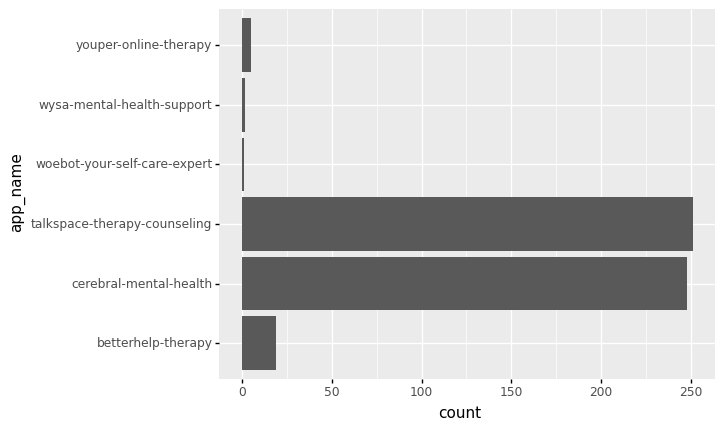

<ggplot: (326133742)>

In [370]:
display(
    ggplot(unlabeled_charge_pos_only, aes('app_name'))
    + geom_bar()
    + coord_flip()
)

In [398]:
predicted_charge_counts = unlabeled_data.groupby('app_name').charge_predicted.value_counts().reset_index(name='charge')

In [399]:
predicted_unresponsive_counts = unlabeled_data.groupby('app_name').unresponsive_predicted.value_counts().reset_index(name='unresponsive')

In [400]:
predicted_bad_counts = unlabeled_data.groupby('app_name').bad_predicted.value_counts().reset_index(name='bad')

In [407]:
all_counts = predicted_charge_counts.merge(predicted_unresponsive_counts, on='app_name').merge(predicted_bad_counts, on='app_name')

In [414]:
all_counts.head(8)

,app_name,charge_predicted,charge,unresponsive_predicted,unresponsive,bad_predicted,bad
0,betterhelp-therapy,0,78,0,88,0,60
1,betterhelp-therapy,0,78,0,88,1,37
2,betterhelp-therapy,0,78,1,9,0,60
3,betterhelp-therapy,0,78,1,9,1,37
4,betterhelp-therapy,1,19,0,88,0,60
5,betterhelp-therapy,1,19,0,88,1,37
6,betterhelp-therapy,1,19,1,9,0,60
7,betterhelp-therapy,1,19,1,9,1,37


In [464]:
pos_counts = all_counts[(all_counts.charge_predicted == 1) &\
           (all_counts.unresponsive_predicted == 1) &\
           (all_counts.bad_predicted == 1)]

In [465]:
neg_review_counts = unlabeled_data.app_name.value_counts().reset_index(name='total')

In [466]:
neg_review_counts = neg_review_counts.sort_values('index')
neg_review_counts.rename(columns={'index':'app_name'}, inplace=True)

In [467]:
pos_counts = pos_counts.merge(neg_review_counts, on='app_name')

In [468]:
pos_counts['other'] = pos_counts.total - (pos_counts.charge + pos_counts.unresponsive + pos_counts.bad)

In [469]:
pos_counts = pos_counts[['app_name', 'charge', 'unresponsive', 'bad', 'other']]

In [470]:
pos_counts

,app_name,charge,unresponsive,bad,other
0,betterhelp-therapy,19,9,37,32
1,cerebral-mental-health,248,131,38,76
2,talkspace-therapy-counseling,251,247,98,270
3,woebot-your-self-care-expert,1,4,7,25
4,wysa-mental-health-support,2,1,3,17
5,youper-online-therapy,5,5,14,113


In [471]:
pos_counts.to_csv('bar_chart_data.csv', index=False)

Data visualized in DataWrapper:
<img src=talkspace-cerebral-bar.png width=750px>